# Preço por Latitude e Longitude

In [4]:
import numpy as np
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.utils.validation import check_is_fitted
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer

In [5]:
def limpeza(caminho):
    # Ler o arquivo CSV do caminho especificado
    df = pd.read_csv(caminho)

    # Filtra linhas onde a localização contém "Capital Federal"
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    # Filtra apenas apartamentos
    mask_apt = df["property_type"] == "apartment"
    # Filtra imóveis com preço abaixo de 400.000 USD
    mask_price = df["price_aprox_usd"] < 400_000

    # Aplica os três filtros ao DataFrame
    df = df[mask_ba & mask_apt & mask_price]

    # Calcula os percentis 10% (low) e 90% (high) da superfície coberta
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    # Cria uma máscara para manter apenas valores entre os percentis 10% e 90%
    mask_area = df["surface_covered_in_m2"].between(low, high)

    # Aplica o filtro de área ao DataFrame
    df = df[mask_area]

    # Divide a string "lat-lon" em duas colunas "lat" e "lon" e converte para tipo float
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    # Remove a coluna original "lat-lon" que não é mais necessária
    df.drop(columns=["lat-lon"], inplace=True)

    # Retorna o DataFrame limpo
    return df

### Exercício:
Use sua função limpeza para criar um DataFrame chamado frame1 a partir do arquivo CSV buenos-aires-1.csv.

In [6]:
frame1 = limpeza("/content/drive/MyDrive/Buenos-Aires-2/buenos-aires-1.csv")
frame1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1343 entries, 4 to 8604
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operation                   1343 non-null   object 
 1   property_type               1343 non-null   object 
 2   place_with_parent_names     1343 non-null   object 
 3   price                       1343 non-null   float64
 4   currency                    1343 non-null   object 
 5   price_aprox_local_currency  1343 non-null   float64
 6   price_aprox_usd             1343 non-null   float64
 7   surface_total_in_m2         965 non-null    float64
 8   surface_covered_in_m2       1343 non-null   float64
 9   price_usd_per_m2            927 non-null    float64
 10  price_per_m2                1343 non-null   float64
 11  floor                       379 non-null    float64
 12  rooms                       1078 non-null   float64
 13  expenses                    349 non-nu

### Exercício:

Use sua função limpeza para criar um DataFrame chamado frame2 a partir do arquivo CSV buenos-aires-2.csv

In [7]:
frame2 = limpeza("/content/drive/MyDrive/Buenos-Aires-2/buenos-aires-2.csv")
frame2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1315 entries, 2 to 8585
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operation                   1315 non-null   object 
 1   property_type               1315 non-null   object 
 2   place_with_parent_names     1315 non-null   object 
 3   price                       1315 non-null   float64
 4   currency                    1315 non-null   object 
 5   price_aprox_local_currency  1315 non-null   float64
 6   price_aprox_usd             1315 non-null   float64
 7   surface_total_in_m2         933 non-null    float64
 8   surface_covered_in_m2       1315 non-null   float64
 9   price_usd_per_m2            891 non-null    float64
 10  price_per_m2                1315 non-null   float64
 11  floor                       390 non-null    float64
 12  rooms                       1059 non-null   float64
 13  expenses                    339 non-nu

### Exercício:
Use pd.concat para concatenar frame1 e frame2 em um novo DataFrame df. Certifique-se de definir o argumento ignore_index como True.

In [8]:
df = pd.concat([frame1, frame2], ignore_index=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2658 entries, 0 to 2657
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operation                   2658 non-null   object 
 1   property_type               2658 non-null   object 
 2   place_with_parent_names     2658 non-null   object 
 3   price                       2658 non-null   float64
 4   currency                    2658 non-null   object 
 5   price_aprox_local_currency  2658 non-null   float64
 6   price_aprox_usd             2658 non-null   float64
 7   surface_total_in_m2         1898 non-null   float64
 8   surface_covered_in_m2       2658 non-null   float64
 9   price_usd_per_m2            1818 non-null   float64
 10  price_per_m2                2658 non-null   float64
 11  floor                       769 non-null    float64
 12  rooms                       2137 non-null   float64
 13  expenses                    688 n

,operation,property_type,place_with_parent_names,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon
0,sell,apartment,|Argentina|Capital Federal|Chacarita|,129000.0,USD,1955949.6,129000.0,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...,-34.584651,-58.454693
1,sell,apartment,|Argentina|Capital Federal|Villa Luro|,87000.0,USD,1319128.8,87000.0,48.0,42.0,1812.500000,2071.428571,NaN,NaN,NaN,http://villa-luro.properati.com.ar/12m82_venta...,-34.638979,-58.500115
2,sell,apartment,|Argentina|Capital Federal|Caballito|,118000.0,USD,1789163.2,118000.0,NaN,54.0,NaN,2185.185185,NaN,2.0,NaN,http://caballito.properati.com.ar/11wqh_venta_...,-34.615847,-58.459957
3,sell,apartment,|Argentina|Capital Federal|Constitución|,57000.0,USD,864256.8,57000.0,42.0,42.0,1357.142857,1357.142857,5.0,2.0,364,http://constitucion.properati.com.ar/k2f0_vent...,-34.625222,-58.382382
4,sell,apartment,|Argentina|Capital Federal|Once|,90000.0,USD,1364616.0,90000.0,57.0,50.0,1578.947368,1800.000000,NaN,3.0,450,http://once.properati.com.ar/suwa_venta_depart...,-34.610610,-58.412511


# Explorar
Na última lição, construímos um modelo linear simples que previa o preço de um apartamento com base em uma característica, "surface_covered_in_m2" (área coberta em m²).

Nesta lição, estamos construindo um modelo de __regressão linear múltipla__ que prevê o preço com base em duas características, "lon" (longitude) e "lat" (latitude).

Isso significa que nossas visualizações de dados agora precisam comunicar três informações: longitude, latitude e preço. Como podemos representar esses três atributos em uma tela bidimensional?

Uma opção é incorporar cor em nosso gráfico de dispersão. Por exemplo, no gráfico de dispersão Mapbox abaixo, a localização de cada ponto representa latitude e longitude, e a cor representa o preço.

### Exercício:
Complete o código abaixo para criar um gráfico de dispersão do Mapbox que mostre a localização dos apartamentos em `df`.

In [9]:
fig = px.scatter_mapbox(
    df,
    lat="lat",
    lon="lon",
    width=600,
    height=600,
    color="price_aprox_usd",
    hover_data=["price_aprox_usd"],
)

fig.update_layout(mapbox_style="open-street-map")

fig.show()

Outra opção é adicionar uma terceira dimensão ao nosso gráfico de dispersão. Podemos plotar a longitude no eixo x e a latitude no eixo y (como fazemos no mapa acima) e, em seguida, adicionar um eixo z com o preço.

### Exercício:
Crie um gráfico de dispersão 3D, com "lon" no eixo x, "lat" no eixo y e "price_aprox_usd" no eixo z.

In [10]:
fig = px.scatter_3d(
    df,
    x="lon",
    y="lat",
    z="price_aprox_usd",
    labels={"lon": "longitude", "lat": "latitude", "price_aprox_usd": "price"},
    width=600,
    height=500,
)

fig.update_traces(
    marker={"size": 4, "line": {"width": 2, "color": "DarkSlateGrey"}},
    selector={"mode": "markers"},
)

fig.show()

# Dividir  
Mesmo que estejamos construindo um modelo diferente, os passos que seguimos serão os mesmos. Vamos separar nossas características (latitude e longitude) do nosso alvo (preço).

### Exercício:
Crie a matriz de características chamada `X_train`. Ela deve conter duas características: ["lon", "lat"].

In [11]:
features = ["lon", "lat"]
X_train = df[features]

### Exercício:
Crie o vetor de alvo chamado `y_train`, que você usará para treinar seu modelo. Seu alvo deve ser "price_aprox_usd". Lembre-se de que, na maioria dos casos, o vetor de alvo deve ser unidimensional.

In [12]:
target = "price_aprox_usd"
y_train = df[target]

# Baseline
Novamente, precisamos estabelecer uma linha de base para que possamos avaliar o desempenho do nosso modelo. Você notará que o valor de `y_mean` não é exatamente o mesmo que foi na lição anterior. Isso ocorre porque adicionamos mais observações aos nossos dados de treinamento.

### Exercício:
Calcule a média do seu vetor de alvo `y_train` e atribua-a à variável `y_mean`.

In [13]:
y_mean = y_train.mean()
y_mean

134732.97340481562

### Exercício:
Crie uma lista chamada `y_pred_baseline` que contenha o valor de `y_mean` repetido para que tenha o mesmo comprimento que `y_train`.

In [14]:
y_pred_baseline = [y_mean] * len(y_train)
y_pred_baseline[:5]

[134732.97340481562,
 134732.97340481562,
 134732.97340481562,
 134732.97340481562,
 134732.97340481562]

### Exercício
Calcule o erro absoluto médio de linha de base para suas previsões em `y_pred_baseline` em comparação com os alvos reais em `y_train`.

In [16]:
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

# print("Mean apt price", round(y_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Baseline MAE: 45422.75


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2658 entries, 0 to 2657
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operation                   2658 non-null   object 
 1   property_type               2658 non-null   object 
 2   place_with_parent_names     2658 non-null   object 
 3   price                       2658 non-null   float64
 4   currency                    2658 non-null   object 
 5   price_aprox_local_currency  2658 non-null   float64
 6   price_aprox_usd             2658 non-null   float64
 7   surface_total_in_m2         1898 non-null   float64
 8   surface_covered_in_m2       2658 non-null   float64
 9   price_usd_per_m2            1818 non-null   float64
 10  price_per_m2                2658 non-null   float64
 11  floor                       769 non-null    float64
 12  rooms                       2137 non-null   float64
 13  expenses                    688 n

# Iterar  
Reserve um momento para rolar para cima e olhar a saída do `df.info()` e verificar os valores na coluna "Non-Null Count".

Devido à matemática que utiliza, um modelo de regressão linear não pode lidar com observações onde há valores ausentes. Você vê alguma coluna onde isso será um problema?

No projeto anterior, simplesmente descartamos as linhas que continham valores NaN, mas isso não é ideal.

Modelos geralmente performam melhor quando têm mais dados para treinar, então cada linha é preciosa. Em vez disso, podemos preencher esses valores ausentes usando informações que obtemos da coluna inteira — um processo chamado imputação.

Existem muitas estratégias diferentes para imputar valores ausentes, e uma das mais comuns é preencher os valores ausentes com a média da coluna.

Além de __preditores__ como `LinearRegression`, o scikit-learn também possui __transformadores__ que ajudam a lidar com problemas como valores ausentes. Vamos ver como um deles funciona e, em seguida, adicioná-lo ao nosso modelo.

## Simple Imputer
O `SimpleImputer` é uma classe do módulo `sklearn.impute` que permite preencher valores ausentes (NaN) em um conjunto de dados. O objetivo é substituir esses valores faltantes por uma estimativa baseada em outras observações do conjunto de dados.

In [18]:
imputer = SimpleImputer()

Assim como um preditor, um transformador possui um método `fit`. Quando você usa o `SimpleImputer` com o método fit, ele analisa os dados de entrada e calcula as estatísticas necessárias para substituir os valores ausentes.

### Exercício:
Ajuste seu transformador `imputer` à matriz de características `X`.

In [20]:
imputer.fit(X_train)

SimpleImputer()

Aqui é onde os transformadores se diferenciam dos preditores.

Em vez de usar um método como `predict`, usamos o método `transform`. Este é o passo em que o transformador preenche os valores ausentes com as médias que ele calculou.

### Exercício:
Use seu `imputer` para transformar a matriz de características `X_train`. Atribua os dados transformados à variável `XT_train`.

In [21]:
XT_train = imputer.transform(X_train)
pd.DataFrame(XT_train, columns=X_train.columns).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2658 entries, 0 to 2657
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   lon     2658 non-null   float64
 1   lat     2658 non-null   float64
dtypes: float64(2)
memory usage: 41.7 KB


Certo! Nossos dados estão livres de valores ausentes, e temos uma boa noção de como os preditores funcionam no scikit-learn.

No entanto, a verdade é que você raramente fará transformações de dados dessa maneira.

Por quê? Um modelo pode exigir vários transformadores, e fazer todas essas transformações uma a uma é lento e provavelmente levará a erros. 🤦‍♀️

Em vez disso, podemos combinar nosso transformador e preditor em um único objeto chamado pipeline.

### Exercício:
Crie um pipeline chamado `model` que contenha um transformador `SimpleImputer` seguido por um preditor `LinearRegression`.

In [22]:
model = make_pipeline(
    SimpleImputer(),
    LinearRegression()
)
model

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('linearregression', LinearRegression())])

### Exercício:

Ajuste seu modelo aos dados, `X_train` e `y_train`.

In [23]:
model.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('linearregression', LinearRegression())])

Sucesso! Vamos ver como nosso modelo treinado se desempenha.

# Avaliar  
Como sempre, começaremos avaliando o desempenho do nosso modelo nos dados de treinamento.

### Exercício:
Usando o método `predict` do seu modelo, crie uma lista de previsões para as observações na sua matriz de características `X_train`. Nomeie essa lista como `y_pred_training`.

In [24]:
y_pred_training = model.predict(X_train)

### Exercício:
Calcule o erro absoluto médio de treinamento para suas previsões em `y_pred_training` em comparação com os alvos reais em `y_train`.

In [25]:
mae_training = mean_absolute_error(y_train, y_pred_training)
print("Training MAE:", round(mae_training, 2))

Training MAE: 42962.72


Parece que nosso modelo tem um desempenho um pouco melhor do que a linha de base. Isso sugere que latitude e longitude não são tão fortes preditores de preço quanto o tamanho.

Agora vamos verificar o desempenho do nosso teste. Lembre-se, uma vez que testamos nosso modelo, não há mais iterações permitidas.

### Exercício:
Importe seus dados de teste `buenos-aires-features.csv` para um DataFrame e gere uma Series de previsões usando seu modelo.

In [26]:
X_test = pd.read_csv("/content/drive/MyDrive/Buenos-Aires-2/buenos-aires-features.csv")[features]
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

,0
0,136372.324695
1,168620.352353
2,130231.628267
3,102497.549527
4,123482.077850


# Comunicar Resultados  
Vamos dar uma olhada na equação que nosso modelo criou para prever o preço com base em latitude e longitude. Precisaremos expandir nossa fórmula para considerar ambas as características.

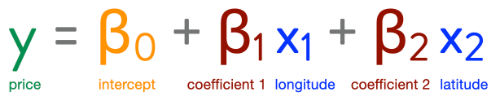

### Exercício:
Extraia o intercepto e os coeficientes do seu modelo.

In [29]:
intercept = model.named_steps["linearregression"].intercept_.round(2)
coefficients = model.named_steps["linearregression"].coef_.round(2)
coefficients

array([196709.42, 765466.58])

### Exercício:
Imprima a equação que seu modelo determinou para prever o preço do apartamento com base em latitude e longitude.

In [ ]:
print(f"price = {intercept} + ({coefficients[0]} * longitude) + ({coefficients[1]} * latitude)")

O que essa equação nos diz? À medida que você se move para o norte e para o leste, o preço previsto do apartamento aumenta.

No início do notebook, você pensou em como representaríamos nosso modelo linear em um gráfico 3D. Se você achou que usaríamos um plano, você está certo!

In [30]:
fig = px.scatter_3d(
    df,
    x="lon",
    y="lat",
    z="price_aprox_usd",
    labels={"lon": "longitude", "lat": "latitude", "price_aprox_usd": "price"},
    width=600,
    height=500,
)

x_plane = np.linspace(df["lon"].min(), df["lon"].max(), 10)
y_plane = np.linspace(df["lat"].min(), df["lat"].max(), 10)
xx, yy = np.meshgrid(x_plane, y_plane)

z_plane = model.predict(pd.DataFrame({"lon": x_plane, "lat": y_plane}))
zz = np.tile(z_plane, (10, 1))

fig.add_trace(go.Surface(x=xx, y=yy, z=zz))

fig.update_traces(
    marker={"size": 4, "line": {"width": 2, "color": "DarkSlateGrey"}},
    selector={"mode": "markers"},
)

fig.show()